## Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%pylab inline
plt.style.use('ggplot')
sns.set()

from sklearn.preprocessing import StandardScaler,MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_classif

from xgboost import XGBClassifier

ImportError: DLL load failed: Não foi possível encontrar o procedimento especificado.

## Defining functions

In [661]:
def dsc_var(feat):   
    '''
    Get the info about the feature from the data dictionary
    '''
    mask = (dic_dados['DICIONÁRIO DE VARIÁVEIS - ENEM 2016'] == feat)
    index_start = dic_dados[mask].index.item()
    index_end  = index_start + 1
    while pd.isnull(dic_dados.iloc[index_end, 0]):
        index_end += 1 
    return dic_dados.iloc[index_start:index_end, :]


def get_info(df):
    '''
    Return a DataFrame with variable infos
    '''
    return pd.DataFrame({'Type': df.dtypes,
                       'Nunique': df.nunique(),
                       'NaN_percent': round(df.isna().sum()/len(df),3)*100,
                       'NaN': df.isna().sum()})
    
def pd_of_stats(df,col):
    '''
    Create a dataframe of descriptive Statistics
    '''
    stats = dict()
    stats['Mean']  = df[col].mean()
    stats['Std']   = df[col].std()
    stats['Var'] = df[col].var()
    stats['Kurtosis'] = df[col].kurtosis()
    stats['Skewness'] = df[col].skew()
    stats['CoefVar'] = stats['Std'] / stats['Mean']
    
    return pd.DataFrame(stats, index = col).T.round(2)


def pd_of_stats_quantile(df,col):
    '''
    Create a dataframe of quantile Statistics
    col is a list of features
    '''
    df_no_na = df[col].dropna()
    stats_q = dict()

    stats_q['Min'] = df[col].min()
    label = {0.25:"Q1", 0.5:'Median', 0.75:"Q3"}
    for percentile in np.array([0.25, 0.5, 0.75]):
        stats_q[label[percentile]] = df_no_na.quantile(percentile)
    stats_q['Max'] = df[col].max()
    stats_q['Range'] = stats_q['Max']-stats_q['Min']
    stats_q['IQR'] = stats_q['Q3']-stats_q['Q1']

    return pd.DataFrame(stats_q, index = col).T.round(2)

def numeric_info(df):
    numeric_feats = df.select_dtypes(include = ['float']).columns.to_list()
    aux_1 = pd_of_stats(df,numeric_feats)
    aux_2 = pd_of_stats_quantile(df,numeric_feats)
    for col in numeric_feats:
        sns.distplot(df[col].dropna())
        plt.show()
    return (pd.concat([aux_1,aux_2], axis = 0))

def cross_val_multiple_ml(estimator, X, y, cv):
    model = estimator.fit(X, y)
    y_pred = cross_val_predict(model, X, y, cv, n_jobs = -1)
    r2_cv = r2_score(y,y_pred)
    rmse_cv = mean_squared_error(y,y_pred, squared=False)
    print(f"R2: {r2_cv} and RMSE: {rmse_cv}" )
    return 

## Load data 

In [360]:
path = "~/Documents/Codenation_challenge/dados/"
in_path = os.path.normcase(path + 'input/')
out_path = os.path.normcase(path+ 'output/')

In [361]:
dic_dados = pd.read_excel(path + 'Dicionario_Microdados_Enem_2016.xlsx')

In [448]:
df_enem_raw =  pd.read_csv(in_path +'train.csv')

In [449]:
df_enem_raw.head()

,Unnamed: 0,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,...,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
0,1,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,2016,4314902,Porto Alegre,43,RS,24,M,0.0,...,5.0,A,A,A,A,A,A,A,B,D
1,2,2c3acac4b33ec2b195d77e7c04a2d75727fad723,2016,2304707,Granja,23,CE,17,F,0.0,...,NaN,A,A,C,A,B,A,A,C,A
2,3,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,2016,2304400,Fortaleza,23,CE,21,F,0.0,...,NaN,A,A,A,A,C,A,A,B,A
3,4,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,2016,3304557,Rio de Janeiro,33,RJ,25,F,0.0,...,5.0,C,A,A,A,A,D,A,A,A
4,5,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,2016,1302603,Manaus,13,AM,28,M,0.0,...,NaN,A,A,A,A,A,A,A,A,A


In [381]:
df_enem_raw.shape

(13730, 48)

Get features available from the test dataset

In [482]:
df_enem_test = pd.read_csv(in_path + 'test.csv')

In [370]:
features = df_enem_test.columns.to_list()

## append the target variable
features.append('NU_NOTA_MT')

print('Features to work with: \n', features)

Features to work with: 
 ['NU_INSCRICAO', 'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO', 'TP_DEPENDENCIA_ADM_ESC', 'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_SABATISTA', 'IN_GESTANTE', 'IN_IDOSO', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'TP_LINGUA', 'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q006', 'Q024', 'Q025', 'Q026', 'Q027', 'Q047', 'NU_NOTA_MT']


In [505]:
df_enem= df_enem_raw[features].copy()

In [486]:
df_enem.shape

(13730, 48)

In [ ]:
pd.set_option('display.max_rows', df_enem_raw.shape[1]+1)

## Get the feature description here 

In [377]:
dsc_var('Q001')

,DICIONÁRIO DE VARIÁVEIS - ENEM 2016,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
307,Q001,"Até que série seu pai, ou o homem responsável ...",A,Nunca estudou.,1,Alfanumérica
308,NaN,NaN,B,Não completou a 4ª série/5º ano do Ensino Fund...,NaN,NaN
309,NaN,NaN,C,"Completou a 4ª série/5º ano, mas não completou...",NaN,NaN
310,NaN,NaN,D,Completou a 8ª série/9º ano do Ensino Fundamen...,NaN,NaN
311,NaN,NaN,E,"Completou o Ensino Médio, mas não completou a ...",NaN,NaN
312,NaN,NaN,F,"Completou a Faculdade, mas não completou a Pós...",NaN,NaN
313,NaN,NaN,G,Completou a Pós-graduação.,NaN,NaN
314,NaN,NaN,H,Não sei.,NaN,NaN


## Raw Data info

In [454]:
df_info = get_info(df_enem)
print(df_info)

                           Type  Nunique  NaN_percent   NaN
NU_INSCRICAO             object    13730          0.0     0
CO_UF_RESIDENCIA          int64       27          0.0     0
SG_UF_RESIDENCIA         object       27          0.0     0
NU_IDADE                  int64       55          0.0     0
TP_SEXO                  object        2          0.0     0
TP_COR_RACA               int64        6          0.0     0
TP_NACIONALIDADE          int64        5          0.0     0
TP_ST_CONCLUSAO           int64        4          0.0     0
TP_ANO_CONCLUIU           int64       11          0.0     0
TP_ESCOLA                 int64        4          0.0     0
TP_ENSINO               float64        3         68.8  9448
IN_TREINEIRO              int64        2          0.0     0
TP_DEPENDENCIA_ADM_ESC  float64        4         68.8  9448
IN_BAIXA_VISAO            int64        2          0.0     0
IN_CEGUEIRA               int64        1          0.0     0
IN_SURDEZ                 int64        2

In [455]:
numeric_feats = df_enem[features].select_dtypes(include = ['int', 'float']).columns.to_list()
numeric_feats

['TP_ENSINO',
 'TP_DEPENDENCIA_ADM_ESC',
 'NU_NOTA_CN',
 'NU_NOTA_CH',
 'NU_NOTA_LC',
 'TP_STATUS_REDACAO',
 'NU_NOTA_COMP1',
 'NU_NOTA_COMP2',
 'NU_NOTA_COMP3',
 'NU_NOTA_COMP4',
 'NU_NOTA_COMP5',
 'NU_NOTA_REDACAO',
 'NU_NOTA_MT']

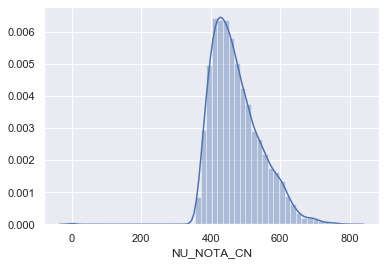

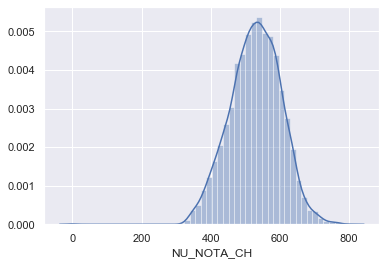

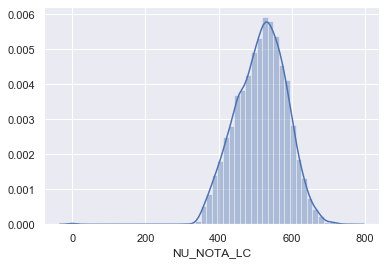

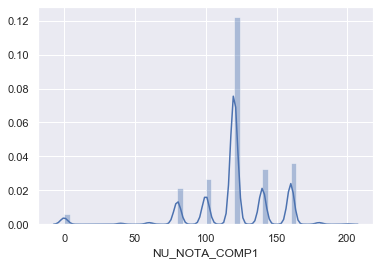

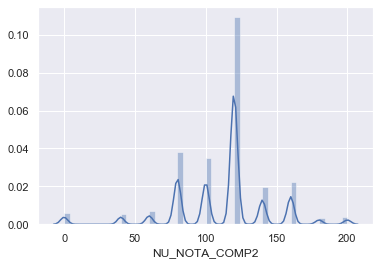

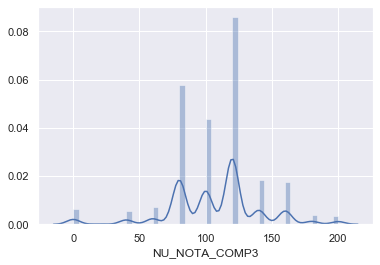

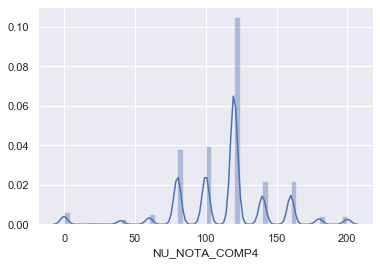

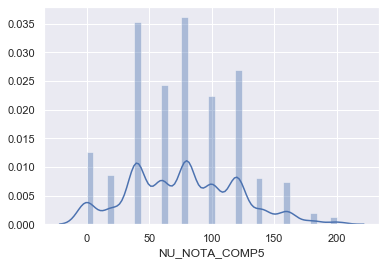

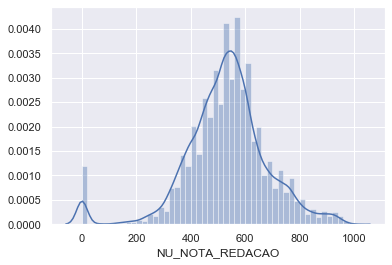

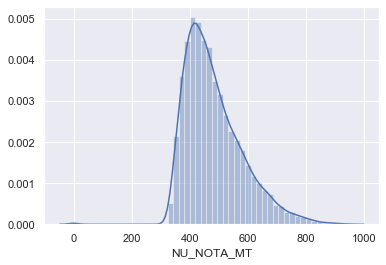

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,NU_NOTA_MT
Mean,473.50,529.66,516.47,119.81,111.92,106.82,113.12,77.37,529.05,482.50
Std,71.09,73.73,68.69,29.85,33.74,34.34,33.48,43.07,154.29,99.83
Var,5054.31,5435.57,4718.07,890.78,1138.22,1179.33,1120.91,1854.78,23806.87,9965.29
Kurtosis,1.68,0.51,1.60,4.53,1.94,1.49,2.26,-0.35,2.24,1.42
Skewness,0.66,-0.16,-0.38,-1.44,-0.64,-0.36,-0.63,0.23,-0.58,0.92
CoefVar,0.15,0.14,0.13,0.25,0.30,0.32,0.30,0.56,0.29,0.21
Min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Q1,420.10,481.00,468.60,120.00,100.00,80.00,100.00,40.00,440.00,409.00
Median,460.40,532.60,521.10,120.00,120.00,120.00,120.00,80.00,540.00,461.30
Q3,515.10,581.90,564.90,140.00,120.00,120.00,120.00,100.00,600.00,537.70


In [456]:
# select only columns that contain 'NU_NOTA_' and get info by passing it to numeric_info
numeric_info(df_enem.filter(like='NU_NOTA_'))

As we evaluated in the EDA, null values in the target are related to absence, lets check it again!
Evaluate the 3597 null values from the target 'NU_NOTA_MT'. 
We also saw that  CN and CH tests happen at the same day, while  LC, MT, Redacao in another day.

In [457]:
# If the sum in each row (among who has Nan for NU_NOTA_MT) is equal 0 it means absence in the day of the test LC , so we add it all to see how many people were absent
null_nota_MT_presenca = df_enem.loc[df_enem['NU_NOTA_MT'].isna(), ['TP_PRESENCA_LC']]
total_absences = (null_nota_MT_presenca == 0).sum(axis = 0).item()
total_disclas = (null_nota_MT_presenca == 2).sum(axis = 0).item()

print('Absent people among null NU_NOTA_MT:', total_absences)
print('Disclassified people among null NU_NOTA_MT:', total_disclas)

Absent people among null NU_NOTA_MT: 3592
Disclassified people among null NU_NOTA_MT: 5


In [806]:
# Understand Missing Values

mask = pd.isnull(df_enem["TP_DEPENDENCIA_ADM_ESC"]) & pd.isnull(df_enem["TP_ENSINO"])
print(f'TP_DEPENDENCIA_ADM_ESC and TP_ENSINO are null at the same indexes, total : {len(df_enem[mask])}')
print('\n Relation of TP_ENSINO and TP_ESCOLA')
print(pd.crosstab(df_enem['TP_ENSINO'], df_enem['TP_ESCOLA']))
print('\n Relation of TP_DEPENDENCIA_ADM_ESC and TP_ESCOLA')
print(pd.crosstab(df_enem['TP_DEPENDENCIA_ADM_ESC'], df_enem['TP_ESCOLA']))

TP_DEPENDENCIA_ADM_ESC and TP_ENSINO are null at the same indexes 9448

 Relation of TP_ENSINO and TP_ESCOLA
TP_ESCOLA     2    3
TP_ENSINO           
1.0        3350  536
2.0          23    3
3.0         340   30

 Relation of TP_DEPENDENCIA_ADM_ESC and TP_ESCOLA
TP_ESCOLA                  2    3
TP_DEPENDENCIA_ADM_ESC           
1.0                       64    0
2.0                     3611    0
3.0                       38    0
4.0                        0  569


In [722]:
states_mapping = dict(zip(df_enem['CO_UF_RESIDENCIA'],df_enem['SG_UF_RESIDENCIA']))
print(states_mapping)

{43: 'RS', 23: 'CE', 33: 'RJ', 13: 'AM', 29: 'BA', 51: 'MT', 26: 'PE', 31: 'MG', 21: 'MA', 24: 'RN', 50: 'MS', 41: 'PR', 15: 'PA', 53: 'DF', 52: 'GO', 32: 'ES', 35: 'SP', 42: 'SC', 22: 'PI', 17: 'TO', 16: 'AP', 25: 'PB', 11: 'RO', 28: 'SE', 27: 'AL', 12: 'AC', 14: 'RR'}


# Transforming data

Neste modelo decidimos não usar variáveis que tragam informações sobre o desempenho nas demais áreas. Estas normalmente são consideradas leakages variáveis, na prática não se disporia destas variáveis para prever a nota.   

In [861]:
df_enem = df_enem_raw[features].copy()

#drop ID data and SG_UF
df_enem.drop(['NU_INSCRICAO', 'SG_UF_RESIDENCIA'], axis =1, inplace = True)

#drop redação partial grades
df_enem.drop(columns = list(df_enem.filter(like = ('NU_NOTA_COMP')).columns), inplace = True)

# drop leakage data NOTAS keep only if the person was present or absent at the day of the math test
grades_features = list(df_enem.loc[:,'TP_PRESENCA_CN':'NU_NOTA_REDACAO'].columns)
grades_features.remove('TP_PRESENCA_LC')
df_enem.drop(columns = grades_features, inplace = True)

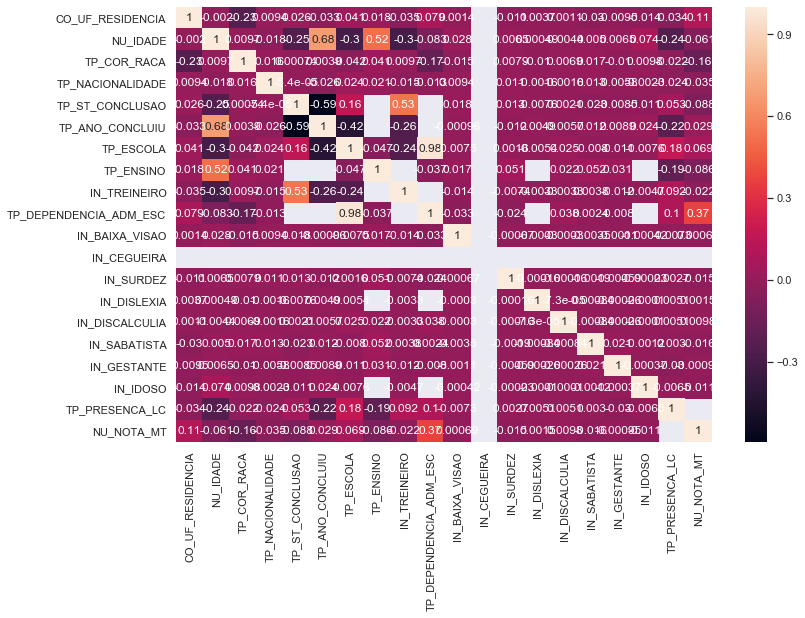

In [830]:
ax = plt.figure(figsize=(12, 8))
ax = sns.heatmap(df_enem.corr(), annot = True)
b, t = plt.ylim() 
plt.ylim(b+0.5, t-0.5)
plt.show() 

# Treat categories

In [862]:
list_CO = df_enem.filter(like = 'CO_').columns.to_list() # features that start with CO
list_IN = df_enem.filter(like = 'IN_').columns.to_list() # features that start with IN - bools
list_TP = df_enem.filter(like = 'TP_').columns.to_list() # features that start with TP
list_Q0 = df_enem.filter(like = 'Q0' ).columns.to_list() # features that start with Q00

list_categories = list_CO + list_IN + list_TP + list_Q0

for col in list_categories:
    df_enem[col] = df_enem[col].astype('category')

In [832]:
get_info(df_enem)

,Type,Nunique,NaN_percent,NaN
CO_UF_RESIDENCIA,category,27,0.0,0
NU_IDADE,int64,55,0.0,0
TP_SEXO,category,2,0.0,0
TP_COR_RACA,category,6,0.0,0
TP_NACIONALIDADE,category,5,0.0,0
TP_ST_CONCLUSAO,category,4,0.0,0
TP_ANO_CONCLUIU,category,11,0.0,0
TP_ESCOLA,category,4,0.0,0
TP_ENSINO,category,3,68.8,9448
IN_TREINEIRO,category,2,0.0,0


In [631]:
#df_enem.drop(columns = ['Q027', 'TP_DEPENDENCIA_ADM_ESC', 'TP_ENSINO'], inplace=True)

# Model

In [912]:
y = np.log(df_enem['NU_NOTA_MT'].fillna(0)+1) # Fill with a flag
#y = df_enem['NU_NOTA_MT'].fillna(0)
X = df_enem.drop(columns=['NU_NOTA_MT'])

#transform
ordinal_features = list_Q0
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy ='most_frequent')),
    ('orde', OrdinalEncoder())])

categorical_features = list_TP
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'constant', fill_value=-1)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

numeric_features = ['NU_IDADE']
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('ord', ordinal_transformer, ordinal_features),
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)])

#models
estimator_dict = dict()
estimator_dict['rf'] = RandomForestRegressor(n_jobs=-1,random_state=0)
estimator_dict['xgb'] = XGBRegressor(random_state=0)
estimator_dict['lr'] = LinearRegression()

## Simple train-test-split

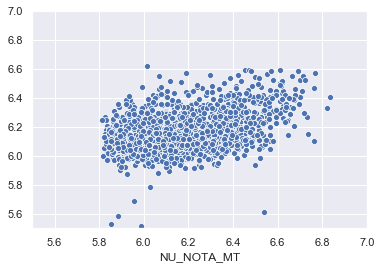

Model rf || MAE = 0.117  || R2 = 0.992


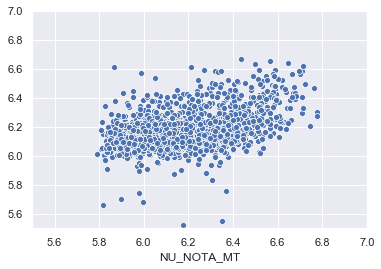

Model xgb || MAE = 0.122  || R2 = 0.989


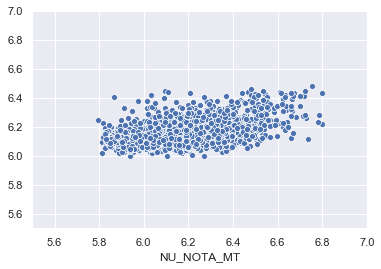

Model lr || MAE = 0.116  || R2 = 0.997


In [914]:
for model in estimator_dict.keys():

    reg = Pipeline(steps=[('preprocessor', preprocessor),
                             ('estimator', estimator_dict[model])])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    reg.fit(X_train, y_train)
    
    score = reg.score(X_test, y_test)
    
    y_pred = reg.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    
    sns.scatterplot(y_test,y_pred)
    plt.xlim(5.5,7)
    plt.ylim(5.5,7)
    plt.show()
    
    print(f"Model {model} || MAE = {round(mae,3)}  || R2 = {round(score,3)}")

## Feature Selection

Model rf || k = 2 || MAE = 0.121 || RMSE = 0.26 || R2 = 0.991
Model rf || k = 4 || MAE = 0.118 || RMSE = 0.233 || R2 = 0.993
Model rf || k = 6 || MAE = 0.12 || RMSE = 0.287 || R2 = 0.989
Model rf || k = 8 || MAE = 0.125 || RMSE = 0.291 || R2 = 0.989
Model rf || k = 10 || MAE = 0.12 || RMSE = 0.261 || R2 = 0.991
Model rf || k = 12 || MAE = 0.119 || RMSE = 0.235 || R2 = 0.993
Model rf || k = 14 || MAE = 0.117 || RMSE = 0.234 || R2 = 0.993
Model rf || k = 16 || MAE = 0.114 || RMSE = 0.208 || R2 = 0.994
Model rf || k = 18 || MAE = 0.12 || RMSE = 0.296 || R2 = 0.988
Model rf || k = 20 || MAE = 0.12 || RMSE = 0.246 || R2 = 0.992
Model rf || k = 22 || MAE = 0.127 || RMSE = 0.287 || R2 = 0.989
Model rf || k = 24 || MAE = 0.122 || RMSE = 0.19 || R2 = 0.995
Model rf || k = 26 || MAE = 0.119 || RMSE = 0.243 || R2 = 0.992
Model rf || k = 28 || MAE = 0.122 || RMSE = 0.23 || R2 = 0.993


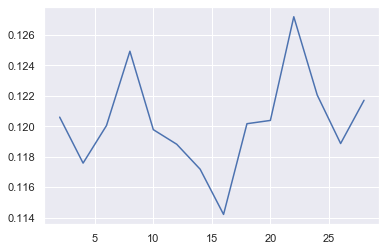

Model xgb || k = 2 || MAE = 0.122 || RMSE = 0.262 || R2 = 0.991
Model xgb || k = 4 || MAE = 0.124 || RMSE = 0.263 || R2 = 0.99
Model xgb || k = 6 || MAE = 0.121 || RMSE = 0.207 || R2 = 0.994
Model xgb || k = 8 || MAE = 0.119 || RMSE = 0.234 || R2 = 0.992
Model xgb || k = 10 || MAE = 0.119 || RMSE = 0.235 || R2 = 0.993
Model xgb || k = 12 || MAE = 0.12 || RMSE = 0.234 || R2 = 0.993
Model xgb || k = 14 || MAE = 0.117 || RMSE = 0.231 || R2 = 0.993
Model xgb || k = 16 || MAE = 0.112 || RMSE = 0.16 || R2 = 0.996
Model xgb || k = 18 || MAE = 0.118 || RMSE = 0.205 || R2 = 0.994
Model xgb || k = 20 || MAE = 0.121 || RMSE = 0.281 || R2 = 0.989
Model xgb || k = 22 || MAE = 0.12 || RMSE = 0.235 || R2 = 0.993
Model xgb || k = 24 || MAE = 0.125 || RMSE = 0.279 || R2 = 0.99
Model xgb || k = 26 || MAE = 0.121 || RMSE = 0.258 || R2 = 0.991
Model xgb || k = 28 || MAE = 0.121 || RMSE = 0.281 || R2 = 0.989


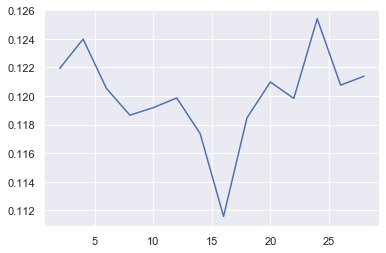

Model lr || k = 2 || MAE = 0.121 || RMSE = 0.262 || R2 = 0.991
Model lr || k = 4 || MAE = 0.121 || RMSE = 0.234 || R2 = 0.993
Model lr || k = 6 || MAE = 0.126 || RMSE = 0.286 || R2 = 0.989
Model lr || k = 8 || MAE = 0.119 || RMSE = 0.201 || R2 = 0.994
Model lr || k = 10 || MAE = 0.118 || RMSE = 0.165 || R2 = 0.996
Model lr || k = 12 || MAE = 0.126 || RMSE = 0.236 || R2 = 0.992
Model lr || k = 14 || MAE = 0.12 || RMSE = 0.201 || R2 = 0.995
Model lr || k = 16 || MAE = 0.116 || RMSE = 0.195 || R2 = 0.995
Model lr || k = 18 || MAE = 0.12 || RMSE = 0.254 || R2 = 0.991
Model lr || k = 20 || MAE = 0.117 || RMSE = 0.249 || R2 = 0.992
Model lr || k = 22 || MAE = 0.115 || RMSE = 0.222 || R2 = 0.993
Model lr || k = 24 || MAE = 0.117 || RMSE = 0.224 || R2 = 0.993
Model lr || k = 26 || MAE = 0.115 || RMSE = 0.152 || R2 = 0.997
Model lr || k = 28 || MAE = 0.119 || RMSE = 0.226 || R2 = 0.993


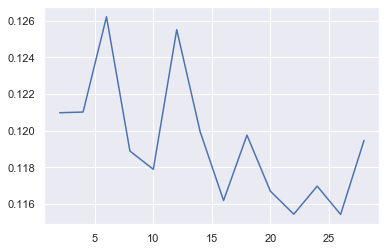

In [915]:
dic_mae = dict()

for model in estimator_dict.keys():

    k_vs_score = []
    end_size = df_enem.shape[1] + 1

    for k in range(2,end_size,2):
        
        reg = Pipeline(steps=[('preprocessor', preprocessor),
                              ('select', SelectKBest(score_func=f_regression, k=k)),
                              ('estimator', estimator_dict[model])])

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
        reg.fit(X_train, y_train)

        score = reg.score(X_test,y_test) 
        
        y_pred = reg.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            
        print("Model {} || k = {} || MAE = {} || RMSE = {} || R2 = {}".format(model, k, round(mae,3), round(rmse,3),round(score,3)))

        k_vs_score.append(mae)
         
    
    dic_mae[model] = k_vs_score


    plt.plot(pd.Series(k_vs_score, index=range(2,end_size,2)))
    plt.show()
   

## Cross validation

In [941]:
estimator_dict = dict()
estimator_dict['rf'] = RandomForestRegressor(max_depth = 5, n_estimators = 500 ,random_state=0)
estimator_dict['xgb'] = XGBRegressor(max_depth = 3, n_estimators = 50, random_state=0)
estimator_dict['lr'] = LinearRegression()


for model in estimator_dict.keys():

    reg = Pipeline(steps=[('preprocessor', preprocessor),
                          ('feature_selection', SelectKBest(k=24)),
                             ('estimator', estimator_dict[model])])

    scores = cross_val_score(reg, X, y, cv=5, scoring = 'r2' ) 
    print (estimator_dict[model])
    print (f'Cross-validated scores: {scores}')
    print (f"Accuracy of {model} with Cross Validation is: {scores.mean() * 100}" )
    print ('\n')

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)
Cross-validated scores: [0.99342849 0.991487   0.99308294 0.99549203 0.99317701]
Accuracy of rf with Cross Validation is: 99.3333494567485


XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=3,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=No

## Grid Search

In [939]:
param_grid = {'feature_selection__k' : [4,8,16,24],
            'estimator': [RandomForestRegressor(n_jobs=-1,random_state=0),
                          XGBRegressor(random_state=0)],
            'estimator__max_depth': [3, 5 , 8],
            'estimator__n_estimators': [50, 100, 500],
            }

reg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('feature_selection', SelectKBest(k=8)),
                      ('estimator', RandomForestRegressor())])

grid_search = GridSearchCV(reg, param_grid, cv=5, scoring = 'neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

print(f"Best score from grid search: {grid_search.score(X_test, y_test)}")
print(f"Best parameters : {grid_search.best_params_}")
print("\n")

Best score from grid search: -0.10270355266157409
Best parameters : {'estimator': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
                      oob_score=False, random_state=0, verbose=0,
                      warm_start=False), 'estimator__max_depth': 5, 'estimator__n_estimators': 500, 'feature_selection__k': 24}




## Final model

    Vamos usar o modelo do Grid Search como modelo final!

```python
y_pred = grid_search.predict(X_test)
```

## TEST

In [973]:
answer = df_enem_test[['NU_INSCRICAO']].copy()
df_enem_test.head(3)

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,41,PR,22,F,3,1,1,5,1,...,40.0,420.0,B,A,C,A,A,C,C,A
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,21,MA,26,F,3,1,1,8,1,...,100.0,580.0,E,B,C,B,B,B,F,A
2,b38a03232f43b11c9d0788abaf060f7366053b6d,23,CE,21,M,1,1,2,0,2,...,80.0,320.0,E,E,D,B,B,A,NaN,A


In [949]:
X_test =  df_enem_test.copy()
#drop SG_UF
X_test.drop(['NU_INSCRICAO','SG_UF_RESIDENCIA'], axis =1, inplace = True)

#drop redação partial grades
X_test.drop(columns = list(X_test.filter(like = ('NU_NOTA_COMP')).columns), inplace = True)

# drop leakage data NOTAS keep only if the person was present or absent at the day of the math test
grades_features = list(X_test.loc[:,'TP_PRESENCA_CN':'NU_NOTA_REDACAO'].columns)
grades_features.remove('TP_PRESENCA_LC')
X_test.drop(columns = grades_features, inplace = True)

list_CO = X_test.filter(like = 'CO_').columns.to_list() # features that start with CO
list_IN = X_test.filter(like = 'IN_').columns.to_list() # features that start with IN - bools
list_TP = X_test.filter(like = 'TP_').columns.to_list() # features that start with TP
list_Q0 = X_test.filter(like = 'Q0' ).columns.to_list() # features that start with Q00

list_categories = list_CO + list_IN + list_TP + list_Q0

for col in list_categories:
    X_test[col] = X_test[col].astype('category')

In [950]:
X_test.head()

,CO_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,...,IN_IDOSO,TP_PRESENCA_LC,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,41,22,F,3,1,1,5,1,NaN,0,...,0,1,B,A,C,A,A,C,C,A
1,21,26,F,3,1,1,8,1,NaN,0,...,0,1,E,B,C,B,B,B,F,A
2,23,21,M,1,1,2,0,2,3.0,0,...,0,1,E,E,D,B,B,A,NaN,A
3,15,27,F,3,1,1,8,1,NaN,0,...,0,0,H,E,G,B,B,A,NaN,A
4,41,18,M,1,1,2,0,2,1.0,0,...,0,1,D,H,H,C,B,A,NaN,A


In [951]:
#transform
ordinal_features = list_Q0
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy ='most_frequent')),
    ('orde', OrdinalEncoder())])

categorical_features = list_TP
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'constant', fill_value=-1)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

numeric_features = ['NU_IDADE']
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('ord', ordinal_transformer, ordinal_features),
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)])

In [974]:
y_pred = grid_search.predict(X_test)
answer['NU_NOTA_MT'] = pd.Series(np.exp(y_pred)-1)

In [990]:
answer.head(20)

,NU_INSCRICAO,NU_NOTA_MT
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,437.749672
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,457.166769
2,b38a03232f43b11c9d0788abaf060f7366053b6d,493.010565
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,0.000000
4,715494628a50142ce8cb17191cfe6d0f3cae0934,516.188063
5,e656d6bad65c93fb2880f1eba5037008c8e75774,486.017680
6,465cd2a6907fb37d9d8ad3c065f0e2dabdba9b13,566.459997
7,11539e86171bf07d3a36f09377d7f54ebcc8406a,426.218591
8,043c544a2104aa8a9849f1a703a08d37a2f16839,436.933844
9,76ba050e64ad100b856f0eaabd8f539d5c7dd185,457.402587


In [992]:
answer.to_csv(out_path+'answer.csv', index = False)